### Imports


In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

### Feature Extraction

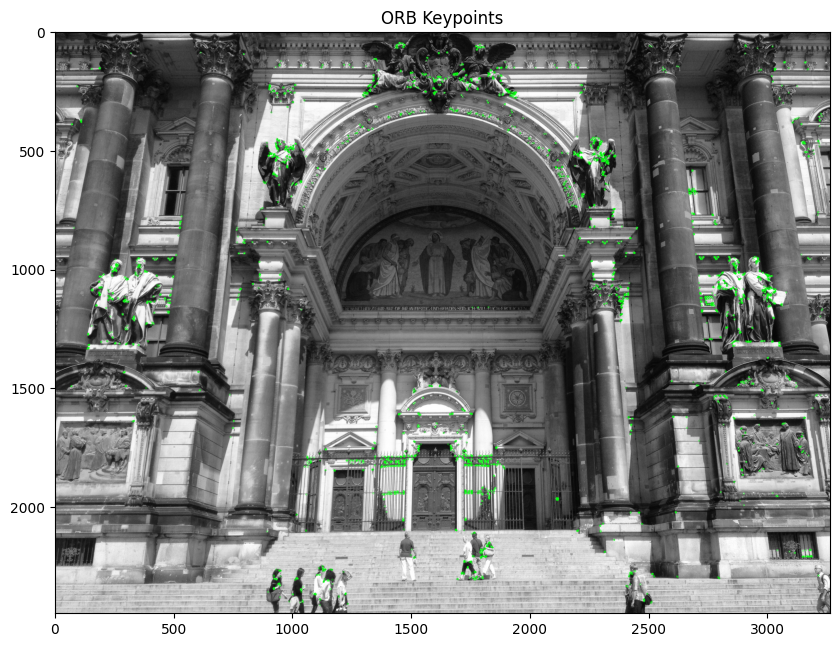

In [4]:
image = cv2.imread("01.jpg", cv2.IMREAD_GRAYSCALE)

# Initialize the ORB detector
orb = cv2.ORB_create(nfeatures = 5000)

# Detect keypoints and compute descriptors
keypoints, descriptors = orb.detectAndCompute(image, None)

# Draw keypoints in the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None, color = (0, 255 ,9), flags = 0)

# Display the image with keypoints
plt.figure(figsize=(10 ,10))
plt.imshow(image_with_keypoints, cmap = 'gray')
plt.title('ORB Keypoints')
plt.show()

### Feature Matching

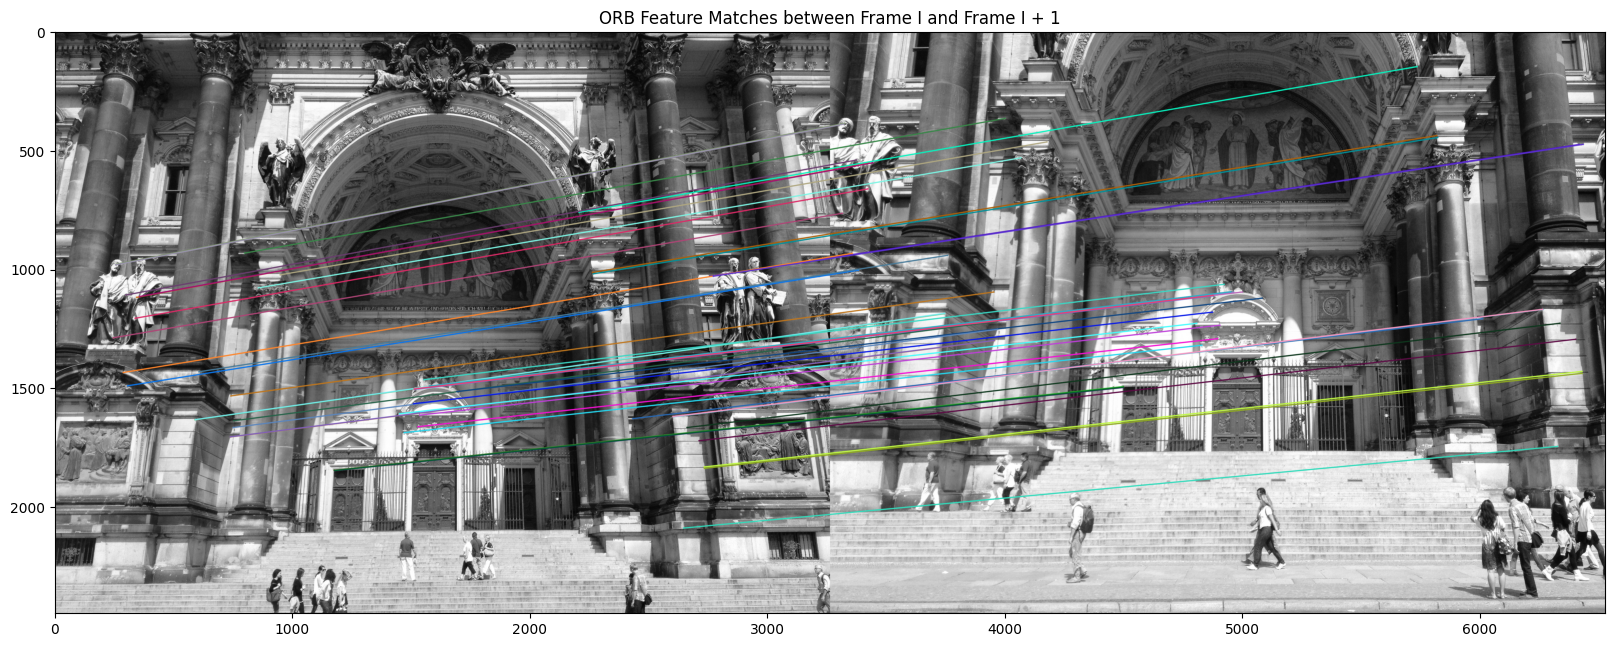

Matched points in Frame I: 
[[1536.      1615.2001 ]
 [2206.6562   762.0481 ]
 [ 589.732   1634.8267 ]
 ...
 [1509.       340.     ]
 [1990.0801   444.96002]
 [2039.0402   489.02405]]


Matched points in frame I+1: 
[[2696.4001   277.2    ]
 [1924.9922   718.8481 ]
 [ 796.2626   734.05457]
 ...
 [2343.       317.     ]
 [1301.76    1497.6001 ]
 [3170.8804   184.89601]]


In [10]:
image1 = cv2.imread("01.jpg", cv2.IMREAD_GRAYSCALE)

image2 = cv2.imread("02.jpg", cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create(nfeatures = 10000)

keypoints1, descriptors1 = orb.detectAndCompute(image1, None)

keypoints2, descriptors2 = orb.detectAndCompute(image2, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

matches  = bf.match(descriptors1, descriptors2)

# Sort
matches = sorted(matches, key = lambda x: x.distance)

# Top N Matches
top_matches = matches[:50]
matched_image = cv2.drawMatches(image1, keypoints1, image2, keypoints2, top_matches , None, flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchesThickness=3)

# Display image with matches
plt.figure(figsize=(20, 15))
plt.imshow(matched_image)
plt.title('ORB Feature Matches between Frame I and Frame I + 1')
plt.show()

# Extract matches points

matched_points1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
matched_points2 = np.float32([keypoints2[m.queryIdx].pt for m in matches])

print("Matched points in Frame I: ")
print(matched_points1)
print("\n")
print("Matched points in frame I+1: ")
print(matched_points2)

### Pose Estimation

In [15]:
K = np.array([
    [3177.000, 0,  1632.000],
    [0,   3177.00, 1224.00],
    [0,     1,      1]
])

# Extract the matche points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
pts2 = np.float32([keypoints2[m.queryIdx].pt for m in matches])

# Compute the Fundamental matrix using RANSAC
F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Select inlier points
pts1_inliers = pts1[inliers.ravel() == 1]
pts2_inliers = pts2[inliers.ravel() == 1]

# estimate essential matrix
E = K.T @ F @ K
_, R, t, mask = cv2.recoverPose(E, pts1_inliers,pts2_inliers, K)

print("Rotation matrix R:")
print(R)
print("\n")
print("Translation vector t: ")
print(t)

Rotation matrix R:
[[ 0.31675648  0.94583661  0.07112266]
 [ 0.70186967 -0.28416826  0.65316717]
 [ 0.63800023 -0.1569761  -0.75386617]]


Translation vector t: 
[[0.01263716]
 [0.03578137]
 [0.99927974]]


### Triangulation for 3D Mapping

In [19]:
# Triangulate from 2D points
def add_ones(x): # Adds one to each 2D point to make it homogeneous  [x, y] -> [x, y, 1]
    return np.concatenate([x, np.ones((x.shape[0], 1))], axis = 1)

# Create 4x4 transformation matrix from rotation R and translation t
T = np.eye(4)
T[0:3, 0:3] = R
T[0:3, 3] = t.T

print("T: ", T)
print("\n")
Kinv = np.linalg.inv(K) # Inverse of intrinsic camera matrix for unprojection 2D -> 3D
print(Kinv, "Kinv")
print("\n")


# Extract the matched points
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])   # Keypoints from image 1
pts2 = np.float32([keypoints2[m.queryIdx].pt  for m in matches])  # Corresponding points in image 2 w.r.t to image1

# Initialize an array to hold resulting 3D points in homogeneous coordinates
ret = np.zeros((pts1.shape[0], 4))   # (N, 4)   --> one 4D point per match

print("Ret initial: ", ret)
print("\n")

pose1 = np.eye(4)                  # Pose 1 is identity (camera 1 is at origin)
# Invert the camera poses to go from world-to-camera to camera-to-world
pose1 = np.linalg.inv(pose1)       # (pose1)^-1  , Camera 1 is at origin
pose2 = np.eye(4) @ T              # Pose 2 is transformed by T (camera2's pose)
pose2 = np.linalg.inv(pose2)       # Camera 2 is placed relative to camera1's using Transformation T


# Triangulate each point pair
for i,p in enumerate(zip(add_ones(pts1),
                         add_ones(pts2))):
    A = np.zeros((4, 4))
    
    # Construct the linear triangulation system Ax = 0 using Direct Linear Transform (DLT) method for each matched point
    A[0] = p[0][0] * pose1[2] - pose2[0]    # For image1 x-coord
    A[1] = p[0][1] * pose1[2] - pose1[1]    # For image1 y-coord
    A[2] = p[1][0] * pose2[2] - pose2[0]    # For image2 x-coord
    A[3] = p[1][1] * pose2[2] - pose2[1]    # For image2 y-coord
    _, _, vt = np.linalg.svd(A)         # Solve Ax = 0 using SVD; solution is the last row of Vᵀ
    ret[i] = vt[3]                      # Homogeneous 3D point [X, Y, Z, W]

print("A", A)
print("\n")

print("Ret before Normalize: ", ret)
print("\n")
# Normalize Homogeneous coordinates by w
ret /= ret[:, 3:]  # Divides each 4D point [x, y, z, w] by w to convert to [x/w, y/w, z/w, 1]
print("Ret After Normalize", ret)


# Filter valid 3d points
# - Only keep points with W > small_threshold (0.005) (to avoid degenerate points or zero-div error)
# - Keep points in front of the camera ret[:, 2] i.e (Z > 0)
good_pts4d = (np.abs(ret[:, 3]) > 0.005) & (ret[:, 2] > 0)

# Final valid 3D Map Points
mapp_pts = [p for i, p in enumerate(ret) if good_pts4d[i]]

T:  [[ 0.31675648  0.94583661  0.07112266  0.01263716]
 [ 0.70186967 -0.28416826  0.65316717  0.03578137]
 [ 0.63800023 -0.1569761  -0.75386617  0.99927974]
 [ 0.          0.          0.          1.        ]]


[[ 3.14762354e-04  2.63027221e-04 -8.35637481e-01]
 [ 0.00000000e+00  5.12032770e-04 -6.26728111e-01]
 [ 0.00000000e+00 -5.12032770e-04  1.62672811e+00]] Kinv


Ret initial:  [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


A [[-3.16756477e-01 -7.01869674e-01  2.03840216e+03  6.66657464e-01]
 [ 0.00000000e+00 -1.00000000e+00  4.89024048e+02  0.00000000e+00]
 [ 2.25204680e+02  2.07041310e+03 -2.39105746e+03  2.31240711e+03]
 [ 1.22044589e+01  1.21052174e+02 -1.39229873e+02  1.34643949e+02]]


Ret before Normalize:  [[ 3.67484359e-01  6.75136229e-01  5.33917535e-04 -6.39645240e-01]
 [ 6.81275922e-01  5.11546035e-01  4.45718980e-04 -5.23625414e-01]
 [-9.71106273e-01 -1.23651247e-01 -1.70504315e-04  2.04115034e-01]
 ...
 [-5.61810418e

In [31]:
print(good_pts4d)
print(type(good_pts4d))

[False False False ... False False False]
<class 'numpy.ndarray'>


In [32]:
good_pts4d.shape

(3021,)

In [23]:
print(len(mapp_pts))
mapp_pts[0].shape

55


(4,)

### Save Map as File

In [25]:
import numpy as np
import open3d as o3d

# mapp_pts is a list of 3D points
mapp_pts = np.array(mapp_pts)

# Create a PointCloud object
pcd = o3d.geometry.PointCloud()

# Convert the Numpy array to Open3D format
pcd.points = o3d.utility.Vector3dVector(mapp_pts[:, :3])

# Create an array of white colors
colors = np.zeros((mapp_pts.shape[0], 3))
colors[:, 1] = 1 # last channel to 1

# Assign the colors to the point cloud
pcd.colors = o3d.utility.Vector3dVector(colors)

# Save the point cloud to a .pcd file
o3d.io.write_point_cloud("points_colored_structurev2.ply", pcd)

True